# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>

## <font color='blue'>Estudo de Caso 5</font>
## <font color='blue'>Geração de Imagens com Modelos Generativos Deep Energy-Based</font>

![DSA](imagens/EC5.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.9


In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [2]:
!pip install -q torch==2.0.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1 requires torch==2.0.0, but you have torch 2.0.1 which is incompatible.


In [3]:
!pip install -q torchvision==0.15.2

In [4]:
!pip install -q pytorch-lightning==2.0.3

In [5]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [6]:
# Imports
import os
import json
import math
import torch
import random
import numpy as np 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [8]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "weber souza" --iversions

Author: weber souza

numpy            : 1.23.5
json             : 2.0.9
matplotlib       : 3.7.0
torchvision      : 0.15.2
pytorch_lightning: 2.0.3
torch            : 2.0.1



**Leia os manuais em pdf no Capítulo 10.**

## Construção do Processo de Modelagem e Treinamento

Serão 7 etapas:

- 1- Carregando os Dados
- 2- Construindo o Modelo Base e Função de Ativação Swish
- 3- Buffer de Amostragem (Sampling Buffer)
- 4- Construção do Modelo Deep Energy-Based
- 5- Construindo os Callbacks
- 6- Treinamento e Avaliação do Modelo
- 7 - Gerando Novas Imagens com o Modelo Treinado

### 1- Carregando os Dados

Primeiro, carregaremos o conjunto de dados MNIST. Observe que precisamos normalizar as imagens entre -1 e 1 em vez de média 0 e std 1 porque durante a amostragem, temos que limitar o espaço de entrada. A escala entre -1 e 1 facilita a implementação.

In [9]:
# Pasta de dados
DATASET_PATH = "dados"

In [10]:
# Pasta para salvar o modelo
CHECKPOINT_PATH = "modelos"

In [11]:
# Seed
pl.seed_everything(42)

Global seed set to 42


42

In [12]:
# Seleciona o device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
print("Device:", device)

Device: cuda:0


In [14]:
# Nome do modelo treinado
modelo_treinado = ["modelos/MNIST.ckpt"]

In [15]:
# Transformações aplicadas em cada imagem 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

In [16]:
# Carregando o conjunto de dados de treinamento
dataset_treino = MNIST(root = DATASET_PATH, 
                       train = True, 
                       transform = transform, 
                       download = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 9912422/9912422 [01:02<00:00, 157827.90it/s]


Extracting dados/MNIST/raw/train-images-idx3-ubyte.gz to dados/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 140715.40it/s]


Extracting dados/MNIST/raw/train-labels-idx1-ubyte.gz to dados/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 1648877/1648877 [00:11<00:00, 147932.07it/s]


Extracting dados/MNIST/raw/t10k-images-idx3-ubyte.gz to dados/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1414503.18it/s]


Extracting dados/MNIST/raw/t10k-labels-idx1-ubyte.gz to dados/MNIST/raw



In [17]:
# Carregando o conjunto de teste
dataset_teste = MNIST(root = DATASET_PATH, 
                      train = False, 
                      transform = transform, 
                      download = True)

In [18]:
# Cria o dataloader de treino
train_loader = data.DataLoader(dataset_treino, 
                               batch_size = 128, 
                               shuffle = True,  
                               drop_last = True,  
                               num_workers = 4, 
                               pin_memory = True)

In [19]:
# Cria o dataloader de teste
test_loader  = data.DataLoader(dataset_teste,
                               batch_size = 256, 
                               shuffle = False, 
                               drop_last = False, 
                               num_workers = 4)

### 2- Construindo o Modelo Base e Função de Ativação Swish

Primeiro, implementamos nosso modelo CNN. As imagens MNIST são de tamanho 28x28, portanto, precisamos apenas de um modelo pequeno. Como exemplo, vamos aplicar várias convoluções com passo 2 que diminuem as imagens. Se você quiser praticar, também pode usar um modelo mais profundo, como uma pequena ResNet, por exemplo.

É uma boa prática usar uma função de ativação suave como Swish em vez de ReLU no modelo de energia. Isso ocorre porque dependeremos dos gradientes que recebermos em relação à imagem de entrada, que não deve ser esparsa.

Swish é uma função de ativação baseada na SiLU, que foi introduzida por outros autores antes da Swish. Abaixo estão os links de referência:

https://arxiv.org/abs/1606.08415

https://arxiv.org/abs/1710.05941v1

https://arxiv.org/abs/1702.03118

In [20]:
# Função de ativação
class Swish(nn.Module):
    
    def forward(self, x):
        return x * torch.sigmoid(x)

In [21]:
# Modelo CNN
class CNNModel(nn.Module):

    def __init__(self, hidden_features = 32, out_dim = 1, **kwargs): # posso receber um vetor de qualquer tamanho
        
        super().__init__()
        
        # Definimos o número de atributos das camadas ocultas intermediárias 
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2
        
        # Série de convoluções e funções de ativação Swish
        self.cnn_layers = nn.Sequential(
            
            # [16x16] - Preenchimento (padding) maior para obter imagem 32x32
            nn.Conv2d(1, c_hid1, kernel_size = 5, stride = 2, padding = 4), 
            Swish(),
            
            #  [8x8]
            nn.Conv2d(c_hid1, c_hid2, kernel_size = 3, stride = 2, padding = 1), 
            Swish(),
            
            # [4x4]
            nn.Conv2d(c_hid2, c_hid3, kernel_size = 3, stride = 2, padding = 1), 
            Swish(),
            
            # [2x2]
            nn.Conv2d(c_hid3, c_hid3, kernel_size = 3, stride = 2, padding = 1), 
            Swish(),
            
            nn.Flatten(),
            nn.Linear(c_hid3*4, c_hid3),
            Swish(),
            nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim = -1)
        return x

**Leia o manual em pdf no Capítulo 10.**

### 3- Buffer de Amostragem (Sampling Buffer)

In [22]:
# Classe
class Sampler:

    # Método construtor
    # model - Rede neural a ser usada para modelar E_theta
    # img_shape - Forma das imagens a modelar
    # sample_size - Tamanho do lote das amostras
    # max_len - Número máximo de pontos de dados para manter no buffer
    def __init__(self, model, img_shape, sample_size, max_len = 8192):

        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    # Função para obter novos batches de imagens "fake"
    # steps - Número de iterações no algoritmo MCMC
    # step_size - Taxa de aprendizado nu no algoritmo acima
    def sample_new_exmps(self, steps = 60, step_size = 10):

        # Escolhemos 95% do lote do buffer, 5% geramos do zero
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k = self.sample_size - n_new), dim = 0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps = steps, step_size = step_size)

        # Adiciona novas imagens ao buffer e remove as antigas, se necessário
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        
        return inp_imgs

    # Função para gerar amostras
    @staticmethod
    def generate_samples(model, inp_imgs, steps = 60, step_size = 10, return_img_per_step = False):

        # Antes do MCMC definimos os parâmetros do modelo como "required_grad=False" 
        # porque estamos interessados apenas nos gradientes da entrada.
        is_training = model.training
        
        model.eval()
        
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True
        
        # Habilita o cálculo do gradiente
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
        
        # Usamos um tensor de buffer no qual geramos ruído a cada iteração do loop.
        # Mais eficiente do que criar um novo tensor a cada iteração.
        noise = torch.randn(inp_imgs.shape, device = inp_imgs.device)
        
        # Lista para armazenar gerações em cada etapa 
        imgs_per_step = []
        
        # Loop por K (steps)
        for _ in range(steps):
            
            # Parte 1: adiciona noise ao input
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            # Parte 2: Calcula gradientes para a entrada atual
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            
            # Para estabilizar e prevenir gradientes muito altos
            inp_imgs.grad.data.clamp_(-0.03, 0.03) 

            # Aplicamos gradientes às nossas amostras atuais
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        
        # Reativa gradientes para parâmetros de treinamento
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        
        # Redefine o cálculo do gradiente para a configuração antes desta função
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

### 4- Construção do Modelo Deep Energy-Based

In [23]:
# Modelo DeepEnergyModel
class DeepEnergyModel(pl.LightningModule):
    
    def __init__(self, img_shape, batch_size, alpha = 0.1, lr = 1e-4, beta1 = 0.0, **CNN_args):
        
        super().__init__()
        
        self.save_hyperparameters()
        
        self.cnn = CNNModel(**CNN_args)
        
        self.sampler = Sampler(self.cnn, img_shape = img_shape, sample_size = batch_size)
        
        self.example_input_array = torch.zeros(1, *img_shape)
 
    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        
        # Os modelos de energia podem ter problemas com o momentum, pois as superfícies de perda 
        # mudam com seus parâmetros. Portanto, definiremos beta1 como 0 por padrão.
        optimizer = optim.Adam(self.parameters(), lr = self.hparams.lr, betas = (self.hparams.beta1, 0.999))
        
        # Decaimento exponencial ao longo de épocas
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma = 0.97) 
        
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        
        # Adicionamos o mínimo de ruído às imagens originais para evitar que o modelo se concentre 
        # em entradas puramente "limpas"
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)
        
        # Amostras fake
        fake_imgs = self.sampler.sample_new_exmps(steps = 60, step_size = 10)
        
        # Prevendo a pontuação de energia para todas as imagens
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim = 0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim = 0)
        
        # Calculando os erros
        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss
        
        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        
        # Para validação, calculamos a divergência contrastiva entre imagens puramente aleatórias e 
        # exemplos não vistos.
        # Observe que a etapa de validação/teste de modelos baseados em energia depende do que estamos 
        # interessados no modelo.
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1
        
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim = 0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim = 0)
        
        cdiv = fake_out.mean() - real_out.mean()
        
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

### 5- Construindo os Callbacks

In [24]:
# Callback de geração de imagens
class GenerateCallback(pl.Callback):

    def __init__(self, batch_size = 8, vis_steps = 8, num_steps = 256, every_n_epochs = 5):
        super().__init__()
        
        # Número de imagens a serem geradas
        self.batch_size = batch_size  
        
        # Número de etapas dentro da geração para visualizar
        self.vis_steps = vis_steps      
        
        # Número de passos a serem dados durante a geração
        self.num_steps = num_steps  
        
        # Salva apenas essas imagens a cada N epochs 
        self.every_n_epochs = every_n_epochs 

    def on_epoch_end(self, trainer, pl_module):
        
        # Pular para todas as outras épocas
        if trainer.current_epoch % self.every_n_epochs == 0:
            
            # Gerar imagens
            imgs_per_step = self.generate_imgs(pl_module)
            
            # Plot 
            for i in range(imgs_per_step.shape[1]):
                
                step_size = self.num_steps // self.vis_steps
                
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                
                grid = torchvision.utils.make_grid(imgs_to_plot, 
                                                   nrow = imgs_to_plot.shape[0], 
                                                   normalize = True, 
                                                   range = (-1,1))
                
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step = trainer.current_epoch)
                
    def generate_imgs(self, pl_module):
        
        pl_module.eval()
        
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        
        start_imgs = start_imgs * 2 - 1
        
        # Rastreamento de gradientes para amostragem 
        torch.set_grad_enabled(True)  
        
        imgs_per_step = Sampler.generate_samples(pl_module.cnn, 
                                                 start_imgs, 
                                                 steps = self.num_steps, 
                                                 step_size = 10, 
                                                 return_img_per_step = True)
        torch.set_grad_enabled(False)
        
        pl_module.train()
        
        return imgs_per_step

In [25]:
# Callback do Sampler
class SamplerCallback(pl.Callback):
    
    def __init__(self, num_imgs=32, every_n_epochs=5):
        
        super().__init__()
        
        # Número de imagens
        self.num_imgs = num_imgs   
        
        # Salva apenas essas imagens a cada N epochs 
        self.every_n_epochs = every_n_epochs 
        
    def on_epoch_end(self, trainer, pl_module):
        
        if trainer.current_epoch % self.every_n_epochs == 0:
            
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k = self.num_imgs), dim = 0)
            
            grid = torchvision.utils.make_grid(exmp_imgs, nrow = 4, normalize = True, range = (-1,1))
            
            trainer.logger.experiment.add_image("sampler", grid, global_step = trainer.current_epoch)

In [26]:
# Callback de outliers
class OutlierCallback(pl.Callback):
    
    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size
    
    def on_epoch_end(self, trainer, pl_module):
        
        with torch.no_grad():
            
            pl_module.eval()
            rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            rand_imgs = rand_imgs * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()
        
        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step = trainer.current_epoch)

### 6- Treinamento e Avaliação do Modelo

In [27]:
# Módulo de treino
def treina_modelo(**kwargs):
    
    # Cria um treinador PyTorch Lightning com os callbacks
    trainer = pl.Trainer(default_root_dir = os.path.join(CHECKPOINT_PATH, "MNIST"),
                         accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
                         devices = 1,
                         max_epochs = 60,
                         gradient_clip_val = 0.1,
                         callbacks = [ModelCheckpoint(save_weights_only = True, 
                                                      mode = "min", 
                                                      monitor = 'val_contrastive_divergence'),
                                      GenerateCallback(every_n_epochs = 5),
                                      SamplerCallback(every_n_epochs = 5),
                                      OutlierCallback(),
                                      LearningRateMonitor("epoch")])
    
    # Nome do modelo
    modelo_treinado = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
    
    # Verifica se o modelo pré-treinado existe. 
    # Se existir, carregamos o modelo e pulamos o treinamento.
    # Se não existir, treinamos por 60 épocas.
    if os.path.isfile(modelo_treinado):
        print("Carregando o modelo treinado...")
        model = DeepEnergyModel.load_from_checkpoint(modelo_treinado)
    else:
        print("Treinando o modelo a partir do zero...")
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    
    return model

> Treina ou carrega o modelo treinado.

In [28]:
%%time

modelo = treina_modelo(img_shape = (1,28,28), 
                       batch_size = train_loader.batch_size,
                       lr = 1e-4,
                       beta1 = 0.0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/weber/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


Carregando o modelo treinado...
CPU times: user 888 ms, sys: 640 ms, total: 1.53 s
Wall time: 2.97 s


### 7 - Gerando Novas Imagens com o Modelo Treinado

In [29]:
modelo.to(device)

DeepEnergyModel(
  (cnn): CNNModel(
    (cnn_layers): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
      (1): Swish()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Swish()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): Swish()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): Swish()
      (8): Flatten(start_dim=1, end_dim=-1)
      (9): Linear(in_features=256, out_features=64, bias=True)
      (10): Swish()
      (11): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [30]:
pl.seed_everything(43)

Global seed set to 43


43

In [31]:
# Callback de geração de imagens
callback = GenerateCallback(batch_size = 4, vis_steps = 8, num_steps = 256)

In [32]:
# Imagens geradas por passo (step)
imgs_per_step = callback.generate_imgs(modelo)

In [33]:
# Coloca na CPU (memória RAM)
imgs_per_step = imgs_per_step.cpu()

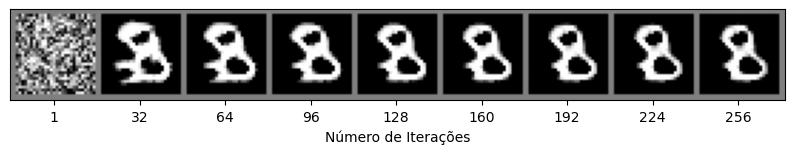

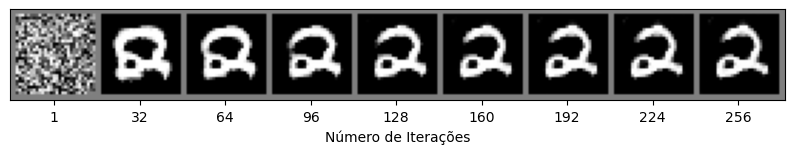

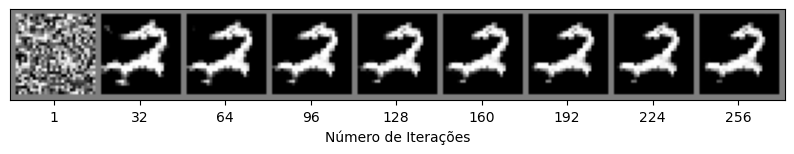

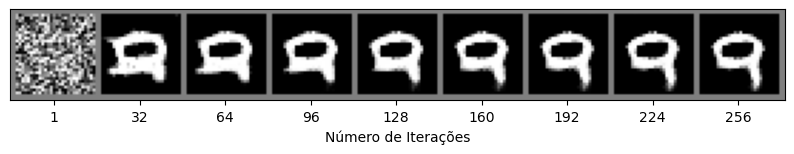

In [34]:
# Loop de geração de imagens com o modelo treinado
for i in range(imgs_per_step.shape[1]):
    
    step_size = callback.num_steps // callback.vis_steps
    
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i], imgs_to_plot], dim = 0)
    
    grid = torchvision.utils.make_grid(imgs_to_plot, 
                                       nrow = imgs_to_plot.shape[0], 
                                       normalize = True, 
                                       range = (-1,1), 
                                       pad_value = 0.5, 
                                       padding = 2)
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize = (10,10))
    plt.imshow(grid)
    plt.xlabel("Número de Iterações")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)], 
               labels = [1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()

Vemos que, embora partindo do ruído logo na primeira etapa, o algoritmo de amostragem obtém formas razoáveis após apenas 128 etapas. Imagens geradas com um modelo baseado em energia. Deep Learning em ação.

## Fim